<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/Time_Series_Anomaly_Detection_with_PyOD_and_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Anomaly Detection with PyOD and PyCaret**

Acknowledgment: 
https://towardsdatascience.com/time-series-anomaly-detection-with-pycaret-706a6e2b2427

**Installing PyCaret**

PyCaret is an open-source, low-code machine learning library and end-to-end model management tool built-in Python for automating machine learning workflows.

In [ ]:
# install slim version (default)
!pip install pycaret

# install the full version
#!pip install pycaret[full]

In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (7,5)

**Dataset**

The NYC taxi passengers dataset that contains the number of taxi passengers from July 2014 to January 2015 at half-hourly intervals.

In [6]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(10)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
5,2014-07-01 02:30:00,2873
6,2014-07-01 03:00:00,2369
7,2014-07-01 03:30:00,2064
8,2014-07-01 04:00:00,2221
9,2014-07-01 04:30:00,2158


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [9]:
!pip install pyyaml==5.4.1

In [10]:
import plotly.express as px

# create moving-averages
df['MA48'] = df['value'].rolling(48).mean()
df['MA336'] = df['value'].rolling(336).mean()
# plot 
fig = px.line(df, x="timestamp", y=['value', 'MA48', 'MA336'], title='NYC Taxi Trips', template = 'plotly_dark')
fig.show()

**Data Preparation**

Since algorithms cannot directly consume date or timestamp data, we will extract the features from the timestamp and will drop the actual timestamp column before training models.

In [11]:
# drop moving-average columns
df.drop(['MA48', 'MA336'], axis=1, inplace=True)
# set timestamp to index
df.set_index('timestamp', drop=True, inplace=True)
# resample timeseries to hourly 
df = df.resample('H').sum()
# creature features from date
df['day'] = [i.day for i in df.index]
df['day_name'] = [i.day_name() for i in df.index]
df['day_of_year'] = [i.dayofyear for i in df.index]
df['week_of_year'] = [i.weekofyear for i in df.index]
df['hour'] = [i.hour for i in df.index]
df['is_weekday'] = [i.isoweekday() for i in df.index]
df.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday
timestamp,,,,,,,
2014-07-01 00:00:00,18971,1,Tuesday,182,27,0,2
2014-07-01 01:00:00,10866,1,Tuesday,182,27,1,2
2014-07-01 02:00:00,6693,1,Tuesday,182,27,2,2
2014-07-01 03:00:00,4433,1,Tuesday,182,27,3,2
2014-07-01 04:00:00,4379,1,Tuesday,182,27,4,2


**Experiment Setup**

Common to all modules in PyCaret, the **setup** function is the first and the only mandatory step to start any machine learning experiment in PyCaret. Besides performing some basic processing tasks by default, PyCaret also offers a wide array of pre-processing features.

Whenever you initialize the setup function in PyCaret, it profiles the dataset and infers the data types for all input features. In this case, you can see **day_name** and **is_weekday** is inferred as categorical and remaining as numeric. You can press enter to continue.

In [12]:
# init setup
from pycaret.anomaly import *
s = setup(df, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(5160, 7)"
2,Missing Values,False
3,Numeric Features,5
4,Categorical Features,2
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(5160, 19)"
9,CPU Jobs,-1


**Model Training**

To check the list of all available algorithms:

In [13]:
# check list of available models
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In this tutorial, **Stochastic Outlier Selection** is used, but the ID ‘**sos**’ can be replaced in the code below with any other model ID to change the algorithm.

In [14]:
# train model: The create_model() function returns a trained model object
sos = create_model('sos', fraction = 0.1)
# assign the anomaly labels to our dataset to analyze the result
sos_results = assign_model(sos)
sos_results.head(10)

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
timestamp,,,,,,,,,
2014-07-01 00:00:00,18971,1,Tuesday,182,27,0,2,1,0.800707
2014-07-01 01:00:00,10866,1,Tuesday,182,27,1,2,0,0.447181
2014-07-01 02:00:00,6693,1,Tuesday,182,27,2,2,0,0.307856
2014-07-01 03:00:00,4433,1,Tuesday,182,27,3,2,1,0.731645
2014-07-01 04:00:00,4379,1,Tuesday,182,27,4,2,0,0.515082
2014-07-01 05:00:00,6879,1,Tuesday,182,27,5,2,1,0.622879
2014-07-01 06:00:00,17565,1,Tuesday,182,27,6,2,0,0.467283
2014-07-01 07:00:00,29722,1,Tuesday,182,27,7,2,0,0.386749
2014-07-01 08:00:00,38266,1,Tuesday,182,27,8,2,0,0.197789


Notice that two new columns are appended i.e. **Anomaly** that contains value 1 for outlier and 0 for inlier and **Anomaly_Score** which is a continuous value a.k.a as decision function (internally, the algorithm calculates the score based on which the anomaly is determined).

In [15]:
sos_results = sos_results.rename(columns={"Anomaly": "Labels"})

In [16]:
sos_results

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Labels,Anomaly_Score
timestamp,,,,,,,,,
2014-07-01 00:00:00,18971,1,Tuesday,182,27,0,2,1,0.800707
2014-07-01 01:00:00,10866,1,Tuesday,182,27,1,2,0,0.447181
2014-07-01 02:00:00,6693,1,Tuesday,182,27,2,2,0,0.307856
2014-07-01 03:00:00,4433,1,Tuesday,182,27,3,2,1,0.731645
2014-07-01 04:00:00,4379,1,Tuesday,182,27,4,2,0,0.515082
...,...,...,...,...,...,...,...,...,...
2015-01-31 19:00:00,56577,31,Saturday,31,5,19,6,0,0.291357
2015-01-31 20:00:00,48276,31,Saturday,31,5,20,6,0,0.166259
2015-01-31 21:00:00,48389,31,Saturday,31,5,21,6,1,0.839078


**Print and Plot the Model**

In [17]:
print(sos)

SOS(contamination=0.1, eps=1e-05, metric='euclidean', perplexity=4.5)


**plot_model()** function can be used to analyze the anomaly detection model over different aspects. This function takes a trained model object and returns a plot.

**t-distributed Stochastic Neighbor Embedding (t-SNE)**

In [ ]:
plot_model(sos, plot = 'tsne')

In [18]:
#Determine the number of anomalous and normal instances in the dataset.

anomalous = sos_results[sos_results['Labels'] == 1]
normal = sos_results[sos_results['Labels'] == 0]
outlier_fraction = len(anomalous)/float(len(normal))

In [19]:
#Now let us print the outlier fraction and number of anomalous and normal instances

print(outlier_fraction)
print("Anomalous Instances : {}".format(len(anomalous)))
print("Normal Instances : {}".format(len(normal)))

0.1111111111111111
Anomalous Instances : 516
Normal Instances : 4644


Show the counts of observations in each categorical bin using bars.

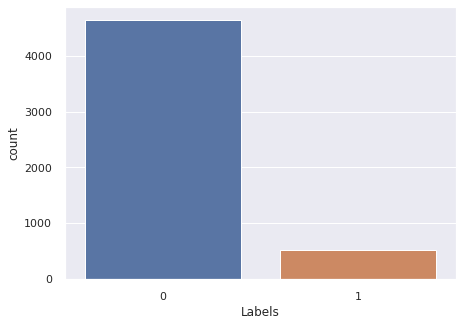

In [22]:
sns.countplot(x="Labels", data=sos_results)

**Check Anomalies**

In [24]:
sos_results[sos_results['Labels'] == 1].head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Labels,Anomaly_Score
timestamp,,,,,,,,,
2014-07-01 00:00:00,18971,1,Tuesday,182,27,0,2,1,0.800707
2014-07-01 03:00:00,4433,1,Tuesday,182,27,3,2,1,0.731645
2014-07-01 05:00:00,6879,1,Tuesday,182,27,5,2,1,0.622879
2014-07-01 13:00:00,37637,1,Tuesday,182,27,13,2,1,0.627495
2014-07-01 15:00:00,37924,1,Tuesday,182,27,15,2,1,0.671506


**Visualize Anomalies**

In [25]:
import plotly.graph_objects as go
# plot value on y-axis and date on x-axis
fig = px.line(sos_results, x=sos_results.index, y="value", title='NYC TAXI TRIPS - UNSUPERVISED ANOMALY DETECTION', template = 'plotly_dark')
# create list of outlier_dates
outlier_dates = sos_results[sos_results['Labels'] == 1].index
# obtain y value of anomalies to plot
y_values = [sos_results.loc[i]['value'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'Labels', 
                marker=dict(color='red',size=10)))
        
fig.show()

Notice that the model has picked several anomalies around Jan 1st which is a new year eve. The model has also detected a couple of anomalies around Jan 18— Jan 22 which is when the North American blizzard (a fast-moving disruptive blizzard) moved through the Northeast dumping 30 cm in areas around the New York City area.

**Create the DeepSVDD Model**

A anomaly detection model is created using create_model() function which takes one mandatory parameter i.e. name of model as a string. This function returns a trained model object.

In [26]:
from pyod.models.deep_svdd import DeepSVDD

In [29]:
clf_name = 'DeepSVD'
clf = DeepSVDD(c=0.3, epochs=30, random_state=123)
clf = create_model(clf)

**Visualize the DeepSVDD model**

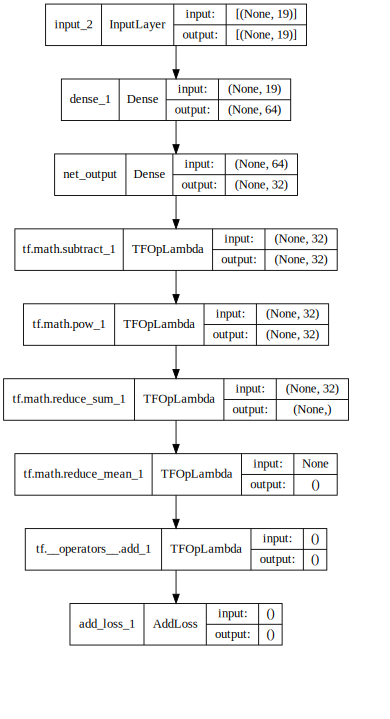

In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(clf.model_, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

**Plot the Loss Functions**

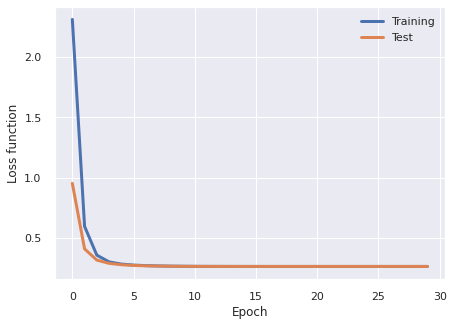

In [31]:
history = clf.history_
plt.plot(history['loss'], linewidth = 3)
plt.plot(history['val_loss'], linewidth = 3)
plt.ylabel('Loss function')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper right')
plt.show()

**Assign the DeepSVDD Model**

This function flags each of the data point in the dataset passed during setup stage as either outlier or inlier (1 = outlier, 0 = inlier) using trained model object passed as model param. create_model() function must be called before using assign_model(). This function returns data frame with Outlier flag (1 = outlier, 0 = inlier) and decision score, when score is set to True.

In [32]:
# assign the anomaly labels to our dataset to analyze the result
clf_results = assign_model(clf)
clf_results.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
timestamp,,,,,,,,,
2014-07-01 00:00:00,18971,1,Tuesday,182,27,0,2,0,0.023800
2014-07-01 01:00:00,10866,1,Tuesday,182,27,1,2,0,0.023801
2014-07-01 02:00:00,6693,1,Tuesday,182,27,2,2,0,0.023801
2014-07-01 03:00:00,4433,1,Tuesday,182,27,3,2,0,0.023801
2014-07-01 04:00:00,4379,1,Tuesday,182,27,4,2,0,0.023801


In [33]:
#Labels
y = clf_results['Anomaly']

#Determine the number of anomalous and normal instances in the dataset.
anomalous = y[y == 1]
normal = y[y == 0]
outlier_fraction = len(anomalous)/float(len(normal))

#Now let us print the outlier fraction and number of anomalous and normal instances
print(outlier_fraction)
print("Anomalous Instances : {}".format(len(anomalous)))
print("Normal Instances : {}".format(len(normal)))

0.0021363371528452125
Anomalous Instances : 11
Normal Instances : 5149


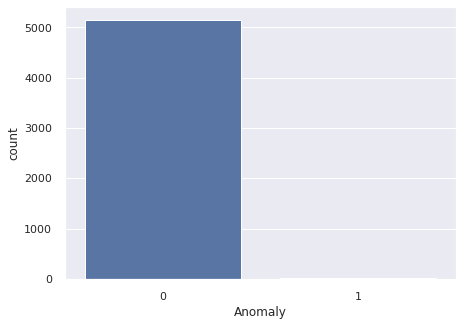

In [34]:
sns.countplot(x="Anomaly", data=clf_results)

**Plot Anomaly Scores**

0.023801233619451523


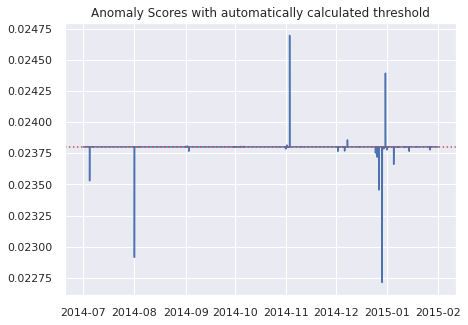

In [35]:
# calculate threshold
print(clf.threshold_)

plt.plot(clf_results['Anomaly_Score']);
plt.axhline(y=clf.threshold_, c='r', ls='dotted', label='threshoold');
plt.title('Anomaly Scores with automatically calculated threshold');

#**Data Splitting with Labels**

https://www.kaggle.com/devavratatripathy/ecg-anomaly-detection-using-autoencoders

https://www.kaggle.com/robinteuwens/anomaly-detection-with-auto-encoders

http://www.pycaret.org/tutorials/html/CLF101.html

**Labels**

In [47]:
 y = sos_results["Labels"].to_numpy()
 y

array([1, 0, 0, ..., 1, 1, 0])

In [48]:
#from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(sos_results, y, test_size = 0.3, random_state = 21)

print('Training Data for Modeling: ' + str(train_data.shape))
print('Test Data For Predictions: ' + str(test_data.shape))

Training Data for Modeling: (3612, 9)
Test Data For Predictions: (1548, 9)


In [ ]:
#train_data.reset_index(drop=True, inplace=True)
#test_data.reset_index(drop=True, inplace=True)

##**Classification**

In [67]:
data = sos_results.sample(frac=0.9, random_state=786)
data_unseen = sos_results.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (4644, 9)
Unseen Data For Predictions: (516, 9)


In [70]:
from pycaret.classification import *
mdl = setup(data=data, target='Labels', train_size=0.7, fix_imbalance = True, session_id=123)

,Description,Value
0,session_id,123
1,Target,Labels
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4644, 9)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
#from pycaret.classification import *
#mdl = setup(data = train_data, target = 'Labels', fix_imbalance = True, session_id=123) 

**Comparing All Models**

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using stratified cross validation for metric evaluation. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) of all the available models in the model library.

In [71]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.043
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.831
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.032
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.536
lightgbm,Light Gradient Boosting Machine,0.9963,0.9999,0.9846,0.9797,0.9817,0.9796,0.9799,0.139
et,Extra Trees Classifier,0.9923,0.9995,0.9384,0.9840,0.9599,0.9556,0.9564,0.586
ridge,Ridge Classifier,0.9458,0.0000,1.0000,0.6584,0.7914,0.7621,0.7857,0.055
lda,Linear Discriminant Analysis,0.9458,0.9996,1.0000,0.6584,0.7914,0.7621,0.7857,0.038
dummy,Dummy Classifier,0.8997,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.024
lr,Logistic Regression,0.8926,0.8128,0.6264,0.4415,0.5007,0.4457,0.4637,0.263


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

**Create a Model**

There are 18 classifiers available in the model library of PyCaret. For example, we can use the logistic regression.


In [72]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9723,0.9993,1.0000,0.7805,0.8767,0.8614,0.8698
1,0.8677,0.9499,0.8438,0.4154,0.5567,0.4893,0.5319
2,0.9569,0.9989,1.0000,0.6957,0.8205,0.7969,0.8139
3,0.9046,0.9611,0.8750,0.5091,0.6437,0.5930,0.6220
4,0.9569,0.9988,1.0000,0.7021,0.8250,0.8013,0.8176
5,0.8615,0.4871,0.0303,0.0714,0.0426,-0.0191,-0.0212
6,0.8800,0.9516,0.9091,0.4545,0.6061,0.5444,0.5900
7,0.8554,0.5443,0.2424,0.2667,0.2540,0.1741,0.1743
8,0.8892,0.6483,0.1515,0.3846,0.2174,0.1697,0.1913
9,0.7815,0.5891,0.2121,0.1346,0.1647,0.0462,0.0478


**Plot a Model**

Before model finalization, the plot_model() function can be used to analyze the performance across different aspects such as AUC, confusion_matrix, decision boundary etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

There are 15 different plots available, please see the plot_model() docstring for the list of available plots.

In [73]:
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**Predict on unseen data**

The predict_model() function is also used to predict on the unseen dataset.

In [52]:
predict_model(lr);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8856,0.9699,0.9259,0.463,0.6173,0.5587,0.6052


**Finalize Model for Deployment**

Model finalization is the last step in the experiment. A normal machine learning workflow in PyCaret starts with setup(), followed by comparing all models using compare_models() and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc.

In [54]:
knn = finalize_model(lr)
predict_model(lr);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8856,0.9699,0.9259,0.463,0.6173,0.5587,0.6052


The predict_model() function is also used to predict on the unseen dataset. 

In [ ]:
unseen_predictions = predict_model(knn, data=test_data)
unseen_predictions.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Labels,Anomaly_Score,Label,Score
timestamp,,,,,,,,,,,
2014-09-28 09:00:00,23095,28,Sunday,271,39,9,7,0,0.116206,0,0.6
2015-01-08 11:00:00,33154,8,Thursday,8,2,11,4,1,0.609937,0,1.0
2015-01-26 10:00:00,27690,26,Monday,26,5,10,1,0,0.201843,0,0.8
2014-09-16 09:00:00,40648,16,Tuesday,259,38,9,2,0,0.290219,0,0.6
2014-11-20 03:00:00,5568,20,Thursday,324,47,3,4,1,0.704642,0,1.0


The Label and Score columns are added onto the data_unseen set. Label is the prediction and score is the probability of the prediction. Notice that predicted results are concatenated to the original dataset while all the transformations are automatically performed in the background.

#**Data Splitting without Labels**

https://github.com/Bcopeland64/Anomaly-Detection-W-PyCaret/blob/main/Anomaly_Detetcion.ipynb

In [ ]:
X_train = sos_results.sample(frac=0.95, random_state=123)
X_train.shape

(4902, 9)

In [ ]:
X_test = sos_results.drop(X_train.index)
X_test.shape

(258, 9)

In [ ]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [ ]:
X_train.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Labels,Anomaly_Score
0,34913,15,Friday,227,33,14,5,0,0.208666
1,49439,1,Saturday,305,44,21,6,1,0.734969
2,8321,1,Friday,213,31,4,5,0,0.337546
3,35984,14,Friday,318,46,12,5,1,0.725424
4,41323,12,Friday,346,50,8,5,0,0.231300


In [ ]:
X_test.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Labels,Anomaly_Score
0,36728,1,Tuesday,182,27,17,2,0,0.147020
1,34591,2,Wednesday,183,27,15,3,0,0.448541
2,33765,5,Saturday,186,27,0,6,0,0.359852
3,28122,5,Saturday,186,27,15,6,0,0.333406
4,7909,9,Wednesday,190,28,2,3,0,0.163969


In [ ]:
from pycaret.anomaly import *
s = setup(data = X_train, normalize=True, session_id=123)

,Description,Value
0,session_id,123
1,Original Data,"(4902, 9)"
2,Missing Values,False
3,Numeric Features,6
4,Categorical Features,3
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(4902, 22)"
9,CPU Jobs,-1


In [ ]:
iforest = create_model('iforest')
print(iforest)

IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=123, verbose=0)


In [ ]:
evaluate_model(iforest)

In [ ]:
iforest_results = assign_model(iforest)
iforest_results.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Labels,Anomaly_Score,Anomaly
0,34913,15,Friday,227,33,14,5,0,-0.154801,0
1,49439,1,Saturday,305,44,21,6,1,0.009642,1
2,8321,1,Friday,213,31,4,5,0,-0.107648,0
3,35984,14,Friday,318,46,12,5,1,-0.031141,0
4,41323,12,Friday,346,50,8,5,0,-0.117359,0


In [ ]:
iforest_predictions = predict_model(iforest, data=X_test)
iforest_predictions.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Labels,Anomaly_Score,Anomaly
0,36728,1,Tuesday,182,27,17,2,0,-0.111565,0
1,34591,2,Wednesday,183,27,15,3,0,-0.097796,0
2,33765,5,Saturday,186,27,0,6,0,-0.091922,0
3,28122,5,Saturday,186,27,15,6,0,-0.107434,0
4,7909,9,Wednesday,190,28,2,3,0,-0.091598,0


In [ ]:
iforest_predictions.value_counts()

value  day  day_name  day_of_year  week_of_year  hour  is_weekday  Labels  Anomaly_Score  Anomaly
54293  19   Sunday    292          42            0     7           0       -0.110629      0          1
19741  18   Thursday  261          38            6     4           0       -0.117577      0          1
30495  13   Monday    286          42            11    1           0       -0.111428      0          1
30428  14   Monday    195          29            11    1           0       -0.108536      0          1
30216  4    Sunday    4            1             20    7           0       -0.056969      0          1
                                                                                                    ..
37158  5    Friday    248          36            10    5           0       -0.138972      0          1
37146  18   Tuesday   322          47            17    2           0       -0.137295      0          1
36981  16   Sunday    320          46            17    7           0       -0.